<center><h1>  Quantifying Interpersonal Synchrony </h1>
<h4>James Trujillo ( j.p.trujillo@uva.nl )<br>
    Updated: 26-06-2024 </h4>

<img src="./images/envision_banner.png" alt="isolated" width="300"/> 
    
## Info 
This module gives an introduction to quantifying interpersonal synchrony of bodily movement using time-lagged windowed cross correlation. Additionally, we will cover extracting and preprocessing motion tracking data collected with Microsoft Kinect Azure.

## Packages:<br>
pandas<br>
numpy<br>
scipy<br>
seaborn


## Module citation: 
Trujillo, J.P. (2024). Quantifying Interpersonal Synchrony (version 2.0.0). [Computer Software]. https://envisionbox.org/interpersonal_synchrony.html <br>
    
    
<b>Location Repository:</b>

https://github.com/jptrujillo/interpersonal_synchrony
    
    
    
<b>Dataset used in this module is provided by</b> : Khebour, I., Brutti, R., Dey,I., Dickler, R., Sikes, K., Lai,
K., Bradford, M., Cates, B., Hansen, P., Jung, C., Wisniewski, B., Terpstra, C., Hirshfield, L., Puntambekar, S.,
Blanchard, N., Pustejovsky, J., & Krishnaswamy, N. (2024). When Text and Speech are Not Enough: A Multimodal Dataset of Collaboration in a Situated Task. Journal of Open Humanities Data, 10:7, pp. 1–7. DOI: https://doi.org/10.5334/johd.168
    


## Preparation
To run this module, you will need to download the data from the Weights Task, by Khebour et al., 2023 (https://zenodo.org/records/10252341) (note that the complete dataset is quite large (28GB)), make a folder called "data" in the same directory as this notebook, and copy the folder "Group_01" into the "data" folder. 


## Introduction
Whether engaged in conversation, walking together, or simply sitting together, people tend to synchronize or entrain their bodily movements. The extent of synchrony has been linked to many outcome measures, such as how many people liked a conversation, how successful a therapy session is, how in-tune to one another the people felt, etc.

Quantifying  interpersonal synchrony can therefore provide an informative measure of social behavior at the dyad-level. This dyad-level focus is particularly important given that social behaviors are embedded in the larger context of people acting as part of a coupled, dynamical system. This module will therefore provide some basic approaches to quantifying, and statistically testing, interpersonal synchrony of bodily movement

This module builds on other EnvisionBOX modules by specifically demonstrating how to utilize (video-based) motion tracking data to calculate synchrony for the whole body, or for specific body parts (e.g., for the torso, head, or hands specifically).

In [1]:
import pandas as pd
import numpy as np
import json 
from collections import defaultdict
import re
import os
import math
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# for simplicity, we'll just analyze one pair of participants in this module, so we can assign this directly. 
# If we wanted to analyze all pairs, we would need to write a loop to load in each of our dyads.

k_path = './data/'
dyad = 'Group_01'

We first need to load the json files and convert them to dataframes for easier working. Json files are hierarchical, nested files, which can be tricky to work with for our purposes. To illustrate, we'll print one frame of the first json file. Notice how there is a lot of useful information there, including the ID of each person detected, as well as joint orientation and position data, frame ID, and timestamps. 
However, it's difficult to see which values correspond to which joint/keyframe on the body, and we have to do a lot of specific indexing to get any particular value out.

In [3]:
k_data_1 = dyad + '-sub1-skeleton.json'
k_data_2 = dyad + '-sub2-skeleton.json'
k_data_m = dyad + '-master-skeleton.json'

with open(os.path.join(k_path, dyad, k_data_m), 'r') as f:
                            datastore_m = json.load(f)
#with open(os.path.join(k_path, dyad, k_data_1), 'r') as f:
#                            datastore_1 = json.load(f)
#with open(os.path.join(k_path, dyad, k_data_2), 'r') as f:
#                            datastore_2 = json.load(f)

In [4]:

print(datastore_m["frames"][0])

{'bodies': [{'body_id': 1, 'joint_orientations': [[0.5497705340385437, -0.48577696084976196, 0.5341244339942932, -0.4201001822948456], [0.5453991293907166, -0.4912715256214142, 0.5290750861167908, -0.4257600009441376], [0.6359391212463379, -0.36168384552001953, 0.6199928522109985, -0.2835049331188202], [0.6566261649131775, -0.3107997477054596, 0.6470006704330444, -0.2315938025712967], [0.8982008695602417, -0.4037829041481018, -0.06570173054933548, 0.1608656346797943], [0.6991719603538513, -0.23059000074863434, -0.2585981786251068, 0.625390887260437], [0.3826797902584076, -0.3161141276359558, -0.1418331116437912, 0.8564527630805969], [0.029028454795479774, 0.5993040800094604, 0.714409589767456, -0.3600151538848877], [-0.0944628044962883, 0.32231709361076355, 0.8750189542770386, -0.348611980676651], [-0.0944628044962883, 0.32231709361076355, 0.8750189542770386, -0.348611980676651], [0.3720167875289917, -0.19425439834594727, -0.3456628620624542, 0.8392769694328308], [0.4116641879081726, 0

In [5]:
def extract_motion_data(datastore, body_id_t = 1):
    data_dict = {}
    num_bodies = []

    # First, we need to get all of the joint names and store them as a list
    joint_names = []
    for key in datastore["joint_names"]:
        joint_names.append(key)

    # Initialize key names for each of the joints, that way we can just append the tracked values 
    # as we loop through the frames
    for name in joint_names:
        data_dict[name] = []

    data_dict["frame"] = []
    data_dict["timestamp"] = []
    data_dict["body_id"] = []
    
    last_frame = datastore["frames"][-1]["frame_id"]
    available_frames = list(set([datastore["frames"][frame]["frame_id"] for frame in range(len(datastore["frames"]))]))
    datastore_frame = 0
    
    # now, we'll go through and collect the actual coordinate data at each frame
    for frame in range(last_frame):
        if frame in available_frames:
            for body in datastore["frames"][datastore_frame]["bodies"]:
                if body["body_id"] ==body_id_t:
                    #print(datastore["frames"][0]["bodies"][0]["joint_orientations"])
                    for joint_id in range(len(body["joint_positions"])):
                        data_dict[joint_names[joint_id]].append(body["joint_positions"][joint_id])
                    data_dict["frame"].append(datastore["frames"][datastore_frame]["frame_id"])
                    data_dict["timestamp"].append(datastore["frames"][datastore_frame]["timestamp_usec"])
                    data_dict["body_id"].append(body["body_id"])
                    datastore_frame +=1
                    num_bodies.append(datastore["frames"][datastore_frame]["num_bodies"])
        else:
            for joint_id in joint_names:
                data_dict[joint_id].append([])
            data_dict["frame"].append(frame)
            data_dict["timestamp"].append([])
            data_dict["body_id"].append([])
            num_bodies.append(0)
            
    data_df = pd.DataFrame.from_dict(data_dict)
    
    return data_df, num_bodies

In [6]:
data_df, num_bodies = extract_motion_data(datastore_m)

While this code will do well enough if you have just one person being tracked by the Kinect, it will run into problems with multiple people being tracked simultaneously. While we could use the body_id value to separate them, this often won't work because the Kinect may not track every person in every frame. When someone is "lost" for a frame, and then tracked again, the body_id's won't necessarily correspond to the same people. 
To illustrate the inconsistent tracking, let's look at the number of tracked bodies across all frames of the video. Remember that there are, in fact, 3 people in every frame.

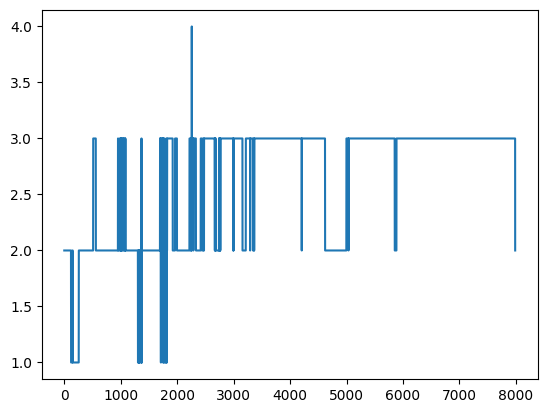

In [7]:
plt.plot(num_bodies)

Therefore, we need to set up some functions to help track individual skeletons based on similarity to previously tracked skeletons. We'll set these up below, and then also define a new function to use these matching functions and return a separate dataframe for each tracked skeleton

In [8]:
def match_skeleton(prev1, prev2, prev3, current):
    # This function serves as a quick check for whether some coordinates match with a previously identified skeleton
    # The function takes 3 arguments: a previous coordinate for each of three possible skeletons, and the new 
    # coordinate. As you'll see below, we'll use the x-coordinate of the Neck, since this will give a person's 
    # horizontal position in the frame. The "prevx" arguments are the last identified x-coordinates of other 
    # skeletons
    # The function here is simple: it just checks whether the new coordinate is very close (defined by threshold) 
    # to a previously identified skeleton. If so, we output that ID. If not, we move to the next skeleton. If the new
    # coordinate is not close to a previous one, and the next skeleton slot is "empty" (==0), we assign this as a new
    # skeleton
    threshold = 50
    # check this first. We assign to the first skeleton, if this is the first frame
    match_1 = np.abs(current - prev1)
    match_2 = np.abs(current - prev2)
    match_3 = np.abs(current - prev3)
    
    if prev1 == 0 or match_1 < threshold:
        match_num = 1
    elif prev2 == 0 or match_2 < threshold:
        match_num = 2
    elif prev3 == 0 or match_3 < threshold:
        match_num = 3
    else:
        #print("NO MATCH!")
        match_num = 0
    
    return match_num

def update_skeleton(data_dict, datastore, body, joint_names, datastore_frame):
    # This is a helper function that updates our data dictionary, providing the joint data, frame, timestamp. and
    # body ID. This is helpful as its own function so we don't need to write all of this out for the specific 
    # dictionary that we are trying to update
    for joint_id in range(len(body["joint_positions"])):
        data_dict[joint_names[joint_id]].append(body["joint_positions"][joint_id])
    data_dict["frame"].append(datastore["frames"][datastore_frame]["frame_id"])
    data_dict["timestamp"].append(datastore["frames"][datastore_frame]["timestamp_usec"])
    data_dict["body_id"].append(body["body_id"])
    
    return data_dict

def update_skeleton_empty(data_dict, frame, joint_names):
    # in cases where a particular ID was not tracked in a particular video frame, we provide blank data.
    # this is just to make sure we have something at each frame of the video. We can use these empty spaces
    # to interpolate the missing data later.
    for joint_id in joint_names:
            data_dict[joint_id].append([])
    data_dict["frame"].append(frame)
    data_dict["timestamp"].append([])
    data_dict["body_id"].append([])
    
    return data_dict

In [9]:
def extract_multiperson_motion_data(datastore):
    data_dict_1 = {}
    data_dict_2 = {}
    data_dict_3 = {}


    # First, we need to get all of the joint names and store them as a list
    joint_names = []
    for key in datastore["joint_names"]:
        joint_names.append(key)

    # Initialize key names for each of the joints, that way we can just append the tracked values 
    # as we loop through the frames
    for name in joint_names:
        data_dict_1[name] = []
        data_dict_2[name] = []
        data_dict_3[name] = []

    data_dict_1["frame"] = []
    data_dict_1["timestamp"] = []
    data_dict_1["body_id"] = []
    data_dict_2["frame"] = []
    data_dict_2["timestamp"] = []
    data_dict_2["body_id"] = []
    data_dict_3["frame"] = []
    data_dict_3["timestamp"] = []
    data_dict_3["body_id"] = []

    last_frame = datastore["frames"][-1]["frame_id"]
    available_frames = list(set([datastore["frames"][frame]["frame_id"] for frame in range(len(datastore["frames"]))]))
    datastore_frame = 0
    #frame = 0
    
    prev1 = 0
    prev2 = 0
    prev3 = 0
    for frame in range(last_frame):
        if frame in available_frames:
            #  we also need to track which skeleton gets updated, 
            # so we can add empty frames to the ones who are not
            updated1 = False
            updated2 = False
            updated3 = False
            
            for body in datastore["frames"][datastore_frame]["bodies"]:
                #print(datastore["frames"][0]["bodies"][0]["joint_orientations"])
                match_num = match_skeleton(prev1, prev2, prev3, body["joint_positions"][3][0])
                if match_num == 1 and not updated1:
                    data_dict_1 = update_skeleton(data_dict_1, datastore, body, joint_names, datastore_frame)
                    prev1 = body["joint_positions"][3][0]
                    updated1 = True
                elif match_num == 2 and not updated2:
                    data_dict_2 = update_skeleton(data_dict_2, datastore, body, joint_names, datastore_frame)
                    prev2 = body["joint_positions"][3][0]
                    updated2 = True
                    
                elif match_num == 3 and not updated3:
                    data_dict_3 = update_skeleton(data_dict_3, datastore, body, joint_names, datastore_frame)
                    prev3 = body["joint_positions"][3][0]
                    updated3 = True
                    
            if not updated1:
                data_dict_1 = update_skeleton_empty(data_dict_1,frame, joint_names)
            if not updated2:
                data_dict_2 = update_skeleton_empty(data_dict_2,frame, joint_names)
            if not updated3:
                data_dict_3 = update_skeleton_empty(data_dict_3,frame, joint_names)

            datastore_frame +=1
                #num_bodies.append(datastore["frames"][datastore_frame]["num_bodies"])
        else:
            data_dict_1 = update_skeleton_empty(data_dict_1,frame, joint_names)
            data_dict_2 = update_skeleton_empty(data_dict_2,frame, joint_names)
            data_dict_3 = update_skeleton_empty(data_dict_3,frame, joint_names)
        #num_bodies.append(0)
    #data_df = pd.DataFrame.from_dict(data_dict)
    data_df_1 = pd.DataFrame.from_dict(data_dict_1)
    data_df_2 = pd.DataFrame.from_dict(data_dict_2)
    data_df_3 = pd.DataFrame.from_dict(data_dict_3)
    return data_df_1, data_df_2, data_df_3

In [10]:
data_df_1, data_df_2, data_df_3 = extract_multiperson_motion_data(datastore_m)

 Now, we need to turn these coordinate data into time-series. So we'll define a function that calculates displacement and its first derivative (velocity). We'll use the vector of velocity values, for each bodily articulator of interest, to calculate synchrony with the same articulator on the other person's body.

In [11]:
def calculate_distance(articulator):
    """
    This just calculates the displacement between each set of points, then the
    velocity from the displacement.
    """
    FPS = 25
    IDX = 0
    dist = []
    spd = []
    for coords in articulator[1:]:
        Prev_coords = articulator[IDX]
        # first calculate displacement
        DISPLACE = math.hypot(float(coords[0]) - float(Prev_coords[0]), float(coords[1]) - float(Prev_coords[1]))
        dist.append(DISPLACE)
        # then calculate speed
        spd.append(DISPLACE * FPS)
        IDX+=1
    return (dist, spd)

Before we can create a time-series, we will need to clean and filter the data a bit. First, to account for dropped frames, we'll interpolate in the missing values. Then, we'll perform some smoothing.
Before running the whole function for smoothing and creating a time-series, let's just take a look at what the different steps do to the data. You may also want to adjust the smoothing function based on this.

First, we'll look at the raw data:

In [12]:
data_df_1.head()

,PELVIS,SPINE_NAVEL,SPINE_CHEST,NECK,CLAVICLE_LEFT,SHOULDER_LEFT,ELBOW_LEFT,WRIST_LEFT,HAND_LEFT,HANDTIP_LEFT,...,FOOT_RIGHT,HEAD,NOSE,EYE_LEFT,EAR_LEFT,EYE_RIGHT,EAR_RIGHT,frame,timestamp,body_id
0,"[168.1407012939453, -97.80023193359375, 1849.1...","[181.1897735595703, -263.8223571777344, 1821.3...","[191.6664581298828, -396.67523193359375, 1799....","[206.22288513183594, -563.4193725585938, 1680....","[235.6161651611328, -533.207275390625, 1700.09...","[362.7315673828125, -486.9346618652344, 1698.4...","[384.7062072753906, -227.0428466796875, 1717.6...","[273.365234375, -63.481689453125, 1622.6069335...","[252.70372009277344, 10.1627779006958, 1573.06...","[173.51681518554688, 74.57855224609375, 1566.9...",...,"[-25.13368034362793, 610.1138916015625, 1793.6...","[210.5140380859375, -618.0216674804688, 1626.1...","[184.03970336914062, -587.377685546875, 1479.5...","[217.11099243164062, -627.3414306640625, 1490....","[290.5926208496094, -655.15771484375, 1580.989...","[168.01451110839844, -630.8812255859375, 1495....","[137.71307373046875, -682.7472534179688, 1603....",0,300222,1
1,"[169.96609497070312, -95.73568725585938, 1855....","[183.22535705566406, -262.66455078125, 1825.70...","[193.82467651367188, -396.1138916015625, 1802....","[207.5433349609375, -562.8726196289062, 1680.4...","[237.31532287597656, -532.8348999023438, 1700....","[365.9932861328125, -488.1191711425781, 1698.4...","[396.3544006347656, -227.68429565429688, 1723....","[284.44696044921875, -63.10097885131836, 1626....","[253.90655517578125, 7.174409866333008, 1576.4...","[175.41232299804688, 73.20365142822266, 1567.3...",...,"[-24.734954833984375, 611.2965087890625, 1796....","[211.56983947753906, -617.315185546875, 1624.9...","[180.81851196289062, -586.5719604492188, 1478....","[215.75868225097656, -625.654296875, 1487.9427...","[292.5594482421875, -651.5172729492188, 1577.5...","[166.5893096923828, -631.02685546875, 1493.971...","[140.19908142089844, -684.9619140625, 1603.453...",1,333511,1
2,"[170.2037811279297, -96.96221160888672, 1857.9...","[183.73374938964844, -262.9219665527344, 1827....","[194.63929748535156, -395.8285827636719, 1803....","[207.31484985351562, -561.232666015625, 1681.5...","[237.1260528564453, -531.4354248046875, 1701.2...","[366.1314697265625, -489.502685546875, 1698.29...","[395.49664306640625, -230.02255249023438, 1722...","[282.000732421875, -65.90885162353516, 1629.85...","[254.8220977783203, 5.269825458526611, 1579.38...","[177.4086456298828, 71.51172637939453, 1567.65...",...,"[-22.86143684387207, 607.8727416992188, 1801.3...","[210.88124084472656, -615.1454467773438, 1625....","[180.75628662109375, -582.4404296875, 1480.093...","[215.42784118652344, -621.5828857421875, 1489....","[291.5913391113281, -648.7600708007812, 1578.5...","[166.42877197265625, -626.8914184570312, 1495....","[139.6960906982422, -682.0348510742188, 1603.4...",2,366888,1
3,"[171.6676483154297, -99.46422576904297, 1859.6...","[184.6793975830078, -265.0267639160156, 1828.9...","[195.21768188476562, -397.744140625, 1806.5034...","[207.53036499023438, -561.4371948242188, 1682....","[237.31927490234375, -531.9646606445312, 1702....","[365.8270263671875, -489.69964599609375, 1699....","[395.92230224609375, -231.0301055908203, 1724....","[280.9895935058594, -68.89738464355469, 1630.8...","[255.21713256835938, 3.226973056793213, 1581.4...","[179.19952392578125, 70.38742065429688, 1568.2...",...,"[-20.060626983642578, 603.8760986328125, 1805....","[210.96495056152344, -614.626708984375, 1626.8...","[180.78900146484375, -579.8770751953125, 1481....","[215.41766357421875, -619.0119018554688, 1490....","[291.4664611816406, -647.3533325195312, 1579.0...","[166.55865478515625, -624.4464111328125, 1496....","[140.02854919433594, -681.0753784179688, 1603....",3,400222,1
4,"[176.2834014892578, -100.657470703125, 1861.28...","[187.59332275390625, -266.1571960449219, 1831....","[196.7790985107422, -398.79620361328125, 1809....","[207.2209014892578, -561.625, 1685.65576

Let's plot the x-position of the head over a 4-second window, to see how this looks without any smoothing. Note that position (y-axis) is given in millimeters. In the Kinect Azure coordinate system, central point in the camera's field of view is given as [0,0,0]. On the x-axis, positive values are to the right of the center. On the y-axis, positive values are <i>below</i> the center (note that this means that more negative values are higher in the image, and more positive values are lower).

Text(0.5, 1.0, 'Raw x-coordinate time-series')

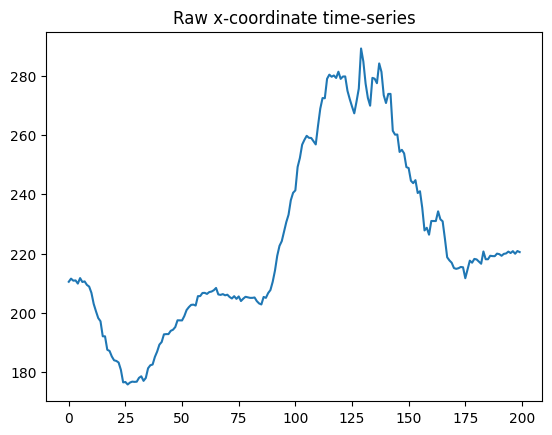

In [13]:
articulator = data_df_1["HEAD"]

x = pd.Series([coords[0] if len(coords)>1 else np.nan for coords in articulator ])
plt.plot(x[0:200])
plt.title("Raw x-coordinate time-series")

Now, let's fill in the small gaps (if there are any dropped frames) and smooth the data.
Here, I'm using the Savitsky-Golay filter, although there are many alternative options. Savitsky-Golay is effectively finding a polynomial trend within a sliding window of the data. This allows you to keep the overal trend of the data while removing noise. The two parameters that we provide are the window size (how many frames), and the polynomial order. You can read more about this filter here: https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html

Try changing the two parameters and see what it does to the resulting data!

Text(0.5, 1.0, 'Smoothed x-coordinate time-series')

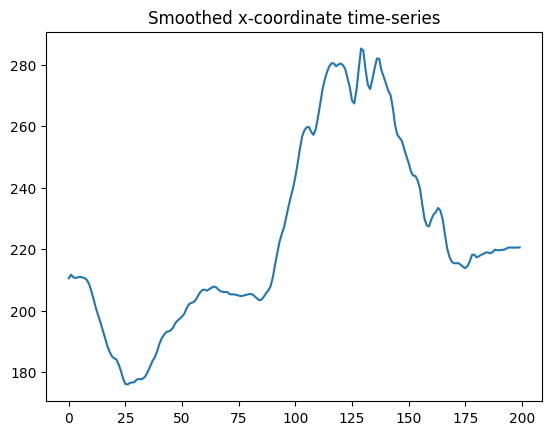

In [14]:
x_s = signal.savgol_filter(x,13,7)
plt.plot(x_s[0:200])
plt.title("Smoothed x-coordinate time-series")

In [15]:
def get_timeseries(articulator):
    
    # split into x, y, z and interpolate
    x_i = pd.Series([coords[0] if len(coords)>1 else np.nan for coords in articulator]).interpolate()
    y_i = pd.Series([coords[1] if len(coords)>1 else np.nan for coords in articulator]).interpolate()
    z_i = pd.Series([coords[2] if len(coords)>1 else np.nan for coords in articulator]).interpolate()
    
    # smooth the data
    x_s = signal.savgol_filter(x_i,15,7)
    y_s = signal.savgol_filter(y_i,15,7)
    z_s = signal.savgol_filter(z_i,15,7)
    
    # now put it all back together to go into the distance function
    smooth_ts = []
    for i in range(len(x_i)):
        smooth_set = [x_s[i], y_s[i], z_s[i]]
        smooth_ts.append(smooth_set)
    
    dist_ts, spd_ts = calculate_distance(smooth_ts)
    
    return pd.Series(dist_ts), pd.Series(spd_ts)

To get a sense of the similarity between time-series, we can plot the movement profiles of the first two participants together. For simplicity, we'll just take a random 100-frame slice (4 seconds) near the beginning of the data.

Notice how you can already spot some moments when both are moving a similar amount at the same time, or perhaps slightly lagged in time. At other moments, they are quite different. This synchrony, whether time-lagged or perfectly in sync, is what we will quantify in the next step.

In [16]:
dist_head_1, spd_head_1 = get_timeseries(data_df_1["HEAD"])
dist_head_2, spd_head_2 = get_timeseries(data_df_2["HEAD"])

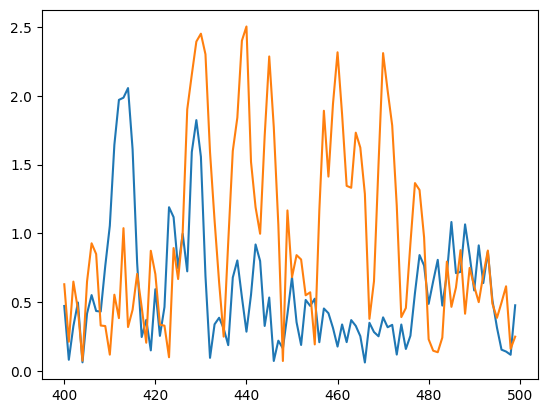

In [17]:
plt.plot(dist_head_1[400:500])
plt.plot(dist_head_2[400:500])


## Calculating Synchrony

Now, we can start calculating interpersonal synchrony of each of these articulators. For this, we'll use Windowed Cross-Correlation (WCC), which is a commonly-used approach, and allows us to calculate synchrony across multiple time-windows. 
The parameters that we use to calculate WCC are quite important, as they will impact the outcome. We will use the suggestion given by Schoenherr and colleagues (2019; https://doi.org/10.1371/journal.pone.0211494), which is to use a bandwidth of 75 or 125 frames (3 or 5 seconds, respectively) and no smoothing/slight smoothing".

In [18]:
# Rolling window time lagged cross correlation
seconds = 2 # how much time-lag do we expect
fps = 25
window_size = 125 # in frames
t_start = 0
t_end = t_start + window_size
step_size = 20 # by how many frames should the window move forward iwth each step
rss=[] 
while t_end < len(dist_head_1):
    d1 = dist_head_1[t_start:t_end]
    d2 = dist_head_2[t_start:t_end]
    rs = [d1.corr(d2.shift(lag)) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

[Text(0.5, 1.0, 'Rolling Windowed Time Lagged Cross Correlation'),
 Text(0.5, 102.72222222222219, 'Offset'),
 Text(120.72222222222221, 0.5, 'Epochs')]

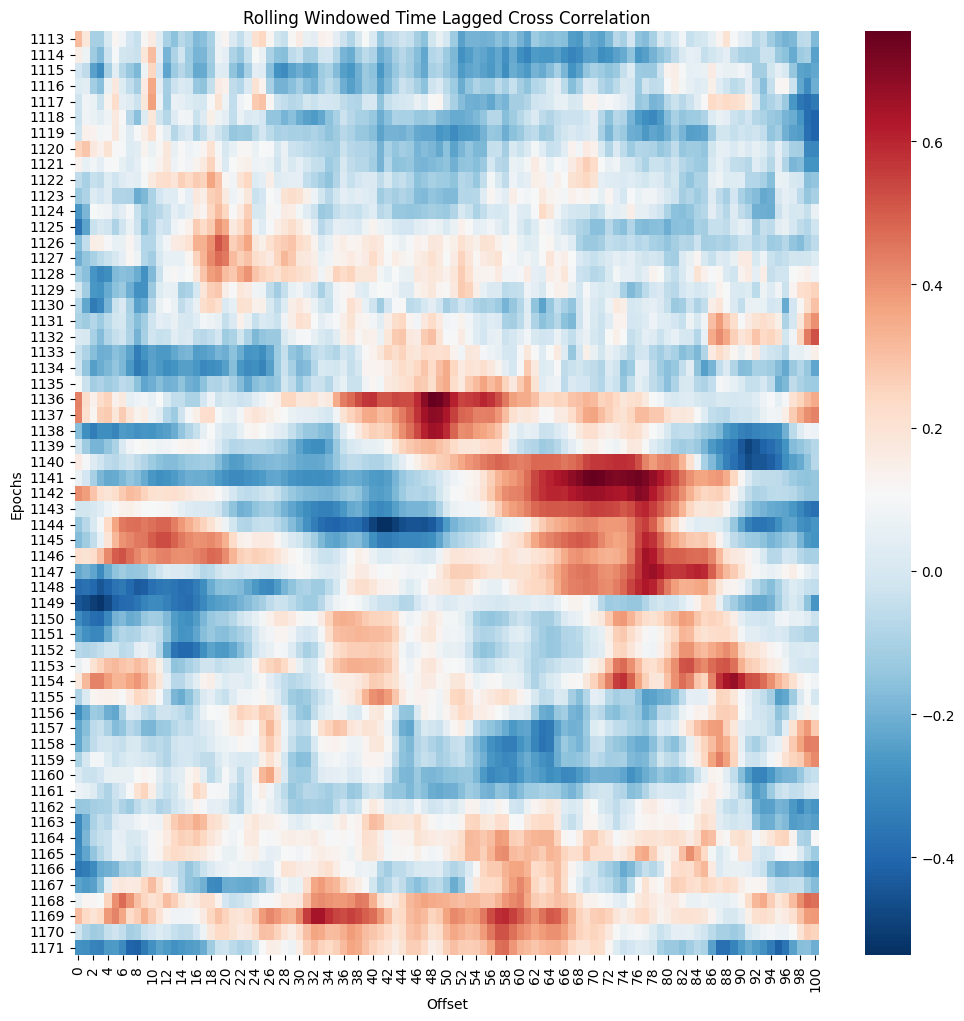

In [19]:
# let's only plot the last 60 epochs 

f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(rss[-60:-1],cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation', xlabel='Offset',ylabel='Epochs')

From this section of the data, we can see (along the y-axis) different moments in time (5 second epochs), and along the x-axis we see the offset of synchrony. The blue colors suggests anti-synchrony, while the red colors suggest synchrony. 

The lag along the x-axis gives an indication of leader-follower relationship, with positive values (right side of the graph) indicating that participant 1 is leading, and negative values (left side of the graph) indicating that participant 2 is leading.

For example, we can see that, particularly between epochs 1135 and 1145, participant 1 is leading, with participant 2's behavior matching participant 1's with a time-lag of approximately 5-30 frames, or within the order of 1 second.


## How Much "Synchrony" Before it's Synchrony?

The values that we've been calculating can certainly be useful for calculating leader-follower directionality, observing trends in the data, etc. However, you may wonder at what point the synchrony values that we are calculating are actually meaningful. Given that humans naturally gesture, and sway, and move on similar time-scales and in similar ways, there is some baseline amount of "synchrony" that we would expect to observe simply by chance. That's why it's good practice to compare your synchrony values against such a baseline to ensure that your method is actually showing some meaningful level of synchrony. 

One of the most common ways to compare synchrony against a baseline is to use pseudo-dyads. In this approach, we simply swap out one of the partner's data in an interaction with someone from a different interaction. The time-series will both be natural behavior, coming from the same data collection procedure, etc, but there should be no true coupling between the two individuals. 

For simplicity (and to reduce computing time), we will load the first 5 dyads and perform our analysis on this subset. 

In [20]:
# loop: load all data, as d1_p1, d1_p2, d2_p1, etc
dyad_list = os.listdir(k_path)
dyad_list = dyad_list[0:5]

# initialize a dictionary that will hold all of our data
full_dataset_head = {}
full_dataset_body = {}
for dyad in dyad_list:
    print("Processing data for " + dyad + "\t")
    k_data_m = dyad + '-master-skeleton.json'
    with open(os.path.join(k_path, dyad, k_data_m), 'r') as f:
                            datastore_m = json.load(f)
            
    data_df_1, data_df_2, _ = extract_multiperson_motion_data(datastore_m)
    # to save on memory, we can immediately get the time-series data that we need for the synchrony analyses, store these, 
    # and then run the synchrony analyses in the next steps, discarding the rest of the motion trackind data for now
    dist_head_1, _ = get_timeseries(data_df_1["HEAD"])
    dist_head_2, _ = get_timeseries(data_df_2["HEAD"])
    dist_body_1, _ = get_timeseries(data_df_1["SPINE_CHEST"])
    dist_body_2, _ = get_timeseries(data_df_2["SPINE_CHEST"])
    
    # now add these to the dictionary
    full_dataset_head[dyad + "_p1"] = dist_head_1
    full_dataset_head[dyad + "_p2"] = dist_head_2
    full_dataset_body[dyad + "_p1"] = dist_body_1
    full_dataset_body[dyad + "_p2"] = dist_body_2

Processing data for Group_01	
Processing data for Group_02	
Processing data for Group_03	
Processing data for Group_04	
Processing data for Group_05	


Here, we package our synchrony calculation into a neat function. 

In [21]:
def calc_synchrony(dist_head_1, dist_head_2):
    # this will be the same approach we used earlier, but now bundled into a function, 
    # so we don't have to put it into the loop
    seconds = 2 # how much time-lag do we expect
    fps = 25
    window_size = 125 # in frames
    t_start = 0
    t_end = t_start + window_size
    step_size = 20 # by how many frames should the window move forward with each step
    rss=[] 
    while t_end < len(dist_head_1):
        d1 = dist_head_1[t_start:t_end]
        d2 = dist_head_2[t_start:t_end]
        # we need to make sure the time-series are the same length, so we'll get the minimum length,
        # then cut them both when we correlate
        min_length = np.min((len(d1),len(d2))) 
        rs = [np.corrcoef(d1[:min_length], d2[:min_length].shift(lag))[1][0] for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rss.append(rs)
        t_start = t_start + step_size
        t_end = t_end + step_size
    rss = pd.DataFrame(rss)
    
    return rss

In [22]:
def calc_synchrony(dist_head_1, dist_head_2):
    # this will be the same approach we used earlier, but now bundled into a function, 
    # so we don't have to put it into the loop
    seconds = 2 # how much time-lag do we expect
    fps = 25
    window_size = 125 # in frames
    t_start = 0
    t_end = t_start + window_size
    step_size = 20 # by how many frames should the window move forward with each step
    rss=[] 
    while t_end < len(dist_head_1):
        d1 = dist_head_1[t_start:t_end]
        d2 = dist_head_2[t_start:t_end]
        # we need to make sure the time-series are the same length, so we'll get the minimum length,
        # then cut them both when we correlate
        min_length = np.min((len(d1),len(d2))) 
        rs = [(d1[:min_length].corr(d2[:min_length].shift(lag))) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
        rss.append(rs)
        t_start = t_start + step_size
        t_end = t_end + step_size
    rss = pd.DataFrame(rss)
    
    return rss

Now, we need to actually calculate synchrony matrices for all of our dyads. However, we also need to summarize our data a bit more. Testing whether synchrony differs between real and fake dyads at any given time point isn't so informative. Particularly given that positive and negative will be reversed if you switch the order of your participants in the cross-correlation.

Instead, we should look at whether the magnitude of synchrony, at different time lags, differs between real and fakse dyads. So in the next step, we'll convert all of our correlation coefficients using Fisher's transform (inverse hyperbolic tangent), and then take the mean at each time (i.e., the mean of each column in our heatmap).

There are also alternative methods of data summarization, such as taking the peak (absolute) correlation value at each time point, as well as the corresponding time-lag with which it is associated. This is called peak-finding, and also allows you to clearly see dynamic changes in leader-follower relationships, and potentially even changes in coupling in terms of how short or long the time-lag is. For now, we will stick to the commonly used, and simple, "grand average" approach.

In [23]:
full_rss_set = {}

index = 1
for group in dyad_list:
    full_rss_set[group] = calc_synchrony(full_dataset_body[group + "_p1"],full_dataset_body[group + "_p2"])
    # Fisher's transform, with shift to absolute
    full_rss_set[group] = np.abs(np.arctanh(full_rss_set[group])) 
    # summarize for each column (time lag)
    full_rss_set[group] = np.nanmean(full_rss_set[group], axis=1) 
    # progress counter
    index +=1



C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\jptru\AppData\Local\Temp\ipykernel_41812\1268615043.py:9: RuntimeWarning: Mean of empty slice
  full_rss_set[group] = np.nanmean(full_rss_set[group], axis=1)


In [24]:
real_mags = [np.nanmean(full_rss_set[group]) for group in full_rss_set.keys()]
print(real_mags)


[0.15526486512888965, 0.15871621416596976, 0.1470382736852567, 0.16636871900925665, 0.17629018681602046]


We can already plot the density of mean absolute synchrony values. This gives us a sense of the strength of coupling overall, averaging across time lags and direction of influence.

<Axes: ylabel='Density'>

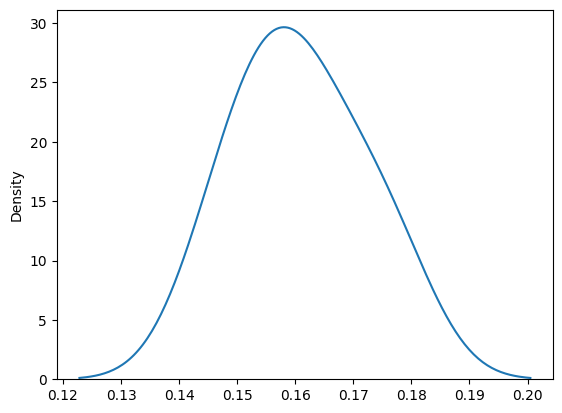

In [25]:
sns.kdeplot(real_mags)

Now, let's shuffle our time-series dictionary, recalculate the synchrony values, and plot everything together.

In [26]:
import random

Notice that the order of the keys is what allowed us to pair the participants up so easily before.

In [27]:
print(full_dataset_body.keys())

dict_keys(['Group_01_p1', 'Group_01_p2', 'Group_02_p1', 'Group_02_p2', 'Group_03_p1', 'Group_03_p2', 'Group_04_p1', 'Group_04_p2', 'Group_05_p1', 'Group_05_p2'])


In [28]:
# I set a seed here, knowing that the sequence generated below will indeed be shuffled as intended. 
# For your own dataset, you will need to check that two members of the same dyad do not get randomly assigned back together
random.seed(3431)

pseudo_dataset_body = full_dataset_body.copy()
keys =  list(pseudo_dataset_body.keys())      
random.shuffle(keys)
pseudo_dataset_body = [(key, pseudo_dataset_body[key]) for key in keys]

Now let's see the ordering of the dictionary after shuffling.

In [29]:
print([val[0] for val in pseudo_dataset_body])

['Group_03_p2', 'Group_02_p2', 'Group_05_p1', 'Group_01_p1', 'Group_05_p2', 'Group_04_p2', 'Group_01_p2', 'Group_03_p1', 'Group_04_p1', 'Group_02_p1']


From here, we could simply compute the grand average of this set of shuffled dyads, and compare it to the real pairs. However, If you want to make this analysis more robust, you can repeat this shuffling many times, to get more possible random pairings, before continuing to the comparison. 

Of course, we need to make sure that each of the random shuffles has only non-matching dyads. So we'll first define a function to check this for us.

In [30]:
# This function makes sure that the random shuffling does not result in any real dyads being put back together
def check_pairing(keys):
    index = 0
    real_pair = False
    while index < len(keys):
        if keys[index].split("_")[1] == keys[index+1].split("_")[1]:
            real_pair = True
            break
        index +=2
    return real_pair

Now, we can wrap all of this into a larger loop that 1) shuffles the data, 2)checks if all the pseudo-pairs are indeed pseudo-pairs and not real-pairs, 3) calculates synchrony for the pseudo pairs, 4) calculates the grand average synchrony score, and 5) adds all the scores to a new list.

In [31]:
pseudo_mags = []

index = 0
while index < 10:    

    pseudo_dataset_body = full_dataset_body.copy()
    keys =  list(pseudo_dataset_body.keys())      
    random.shuffle(keys)
    #pseudo_dataset_body = [(key, pseudo_dataset_body[key]) for key in keys]
    
    real_pair_present = check_pairing(keys)
    if not real_pair_present:
        print("working on set " +  str(index) + "\t")
        pseudo_dataset_body = [(keys[idx], pseudo_dataset_body[key]) for idx,key in enumerate(keys)]
        
        pseudo_rss_set = []

        #p_keys = list(pseudo_dataset_body.keys())
        key_index = 0
        pseudo_pair_index = 0

        while key_index < len(pseudo_dataset_body):
            pseudo_rss_set.append(calc_synchrony(pseudo_dataset_body[key_index][1:][0],pseudo_dataset_body[key_index+1][1:][0]))
            # Fisher's transform, with shift to absolute
            pseudo_rss_set[pseudo_pair_index] = np.abs(np.arctanh(pseudo_rss_set[pseudo_pair_index])) 
            # summarize for each column (time lag)
            pseudo_rss_set[pseudo_pair_index] = np.nanmean(pseudo_rss_set[pseudo_pair_index], axis=1) 
            # remove missing values
            pseudo_rss_set[pseudo_pair_index] =  [np.nan if val == np.inf else val for val in pseudo_rss_set[pseudo_pair_index]]
            # progress counters
            key_index += 2
            pseudo_pair_index += 1
        index +=1
        [pseudo_mags.append(np.nanmean(pair)) for pair in pseudo_rss_set]
    

working on set 0	


C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\jptru\AppData\Local\Temp\ipykernel_41812\2191564174.py:27: RuntimeWarning: Mean of empty slice
  pseudo_rss_set[pseudo_pair_index] = np.nanmean(pseudo_rss_set[pseudo_pair_index], axis=1)
C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\jptru\AppData\Local\Programs\Python\Python312\Lib\

working on set 1	
working on set 2	
working on set 3	
working on set 4	
working on set 5	
working on set 6	
working on set 7	
working on set 8	
working on set 9	


We can plot the grand average synchrony scores for the real pairs and pseudo pairs to already have an impression of whether or not they are different. What do you notice about the two distributions?
We'll use Seaborn's density plots to show how the synchrony scores distribute. We'll use the axvline function to add a vertical line for the average scores.

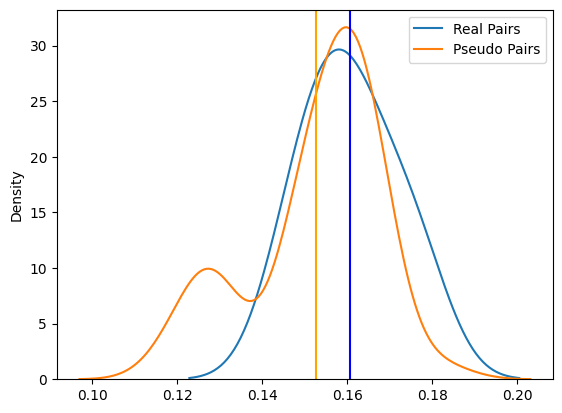

In [32]:
sns.kdeplot(real_mags, label="Real Pairs")
sns.kdeplot(pseudo_mags, label="Pseudo Pairs")
plt.axvline(x=np.mean(real_mags), color="blue")
plt.axvline(x=np.mean(pseudo_mags), color="orange")
plt.legend()

You may have noted that 1) the real pairs have a somewhat more singular peak in their distribution, which shows that all of the real pairs exhibit a similar level of synchrony. Additionally, while the pseudo pairs are less "peaky" in the distribution, the mean is likely quite close to that of the real pairs. This is quite common with this type of baseline test, and reflects the fact that both time-series have similar temporal properties and that the two individuals, while not interacting with one another in the case of the pseudo pairs, were engaged in the same task, in the same context, etc. 

For more in-depth reading on different ways to test synchrony against a baseline using surrogate data methods, as well as ways to summarize synchrony data for testing, see Moulder et al., 2018 https://doi.org/10.1037/met0000172

## Cross-Wavelet Analysis

While cross-correlation analysis can be insightful, and does allow for testing synchrony with varying time-lag, it is limited in that it is unable to account for the multiple embedded time-scales at which behavior unfolds. For example, head movement may capture short, rapid movements (e.g., nodding), but also longer, slower movements, such as tilting the head forward while also leaning forward. Importantly, interactants may only synchronize at the level of one of these time-scales (at one given moment, or at all across the entire interaction). In order to capture this, we need to decompose the time-series into components that represent these different time-scales, and quantify the extent of synchrony for each of these time-scales. For this, we will use Cross-Wavelet analysis.  

.... under construction ....